In [1]:
import csv
import random
import pandas as pd
from tqdm import tqdm
from itertools import islice
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
from datasets import load_dataset

SEED = 1337
random.seed(SEED)

INFO 03-16 01:48:59 __init__.py:190] Automatically detected platform cuda.


In [2]:
dataset = load_dataset("EdinburghNLP/xsum")
dataset

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [3]:
df = pd.concat([dataset['train'].to_pandas(), dataset['validation'].to_pandas(), dataset['test'].to_pandas()])
df.head()

,document,summary,id
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...,35232142
1,A fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...,40143035
2,Ferrari appeared in a position to challenge un...,Lewis Hamilton stormed to pole position at the...,35951548
3,"John Edward Bates, formerly of Spalding, Linco...",A former Lincolnshire Police officer carried o...,36266422
4,Patients and staff were evacuated from Cerahpa...,An armed man who locked himself into a room at...,38826984


In [4]:
df.isna().sum()

document    0
summary     0
id          0
dtype: int64

In [5]:
df["summary_length"] = df["summary"].str.len()
df["document_length"] = df["document"].str.len()

In [6]:
df = df[(df["summary_length"] >= 10) & (df["document_length"] >= 50)]

In [7]:
df.duplicated(subset="document").sum()

np.int64(171)

In [9]:
df.drop_duplicates(subset=["document"], inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
len(df)

226394

In [11]:
def batchify(iterable, batch_size):
    """Splits an iterable into smaller batches."""
    iterable = iter(iterable)
    while batch := list(islice(iterable, batch_size)):
        yield batch

def save_to_csv(path, prompts, responses, temperature, top_p, top_k):
    """Saves prompts, responses and sampling parameters to a CSV file."""
    with open(path, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for prompt, response in zip(prompts, responses):
            writer.writerow([prompt, response, temperature, top_p, top_k])

def generate_responses(model, prompts, sampling_params):
    """Generate a batch of outputs using vLLM with customizable sampling parameters."""
    outputs = model.chat(prompts, sampling_params=sampling_params, use_tqdm=False)
    
    return [sample.outputs[0].text.replace('"', '') for sample in outputs]

In [12]:
BASE_PROMPT = [{"role": "system", "content": "You are a helpful assistant for writing news articles based on provided one sentence summaries. Based on provided summary generate a news article. MAKE SURE TO REPLAY ONLY WITH THE NEWS ARTICLE."},
                {"role": "user", "content": "Summary: \n {summary}"},
                {"role": "assistant", "content": "News article: \n"}]

In [13]:
prompts = [
    [
        BASE_PROMPT[0],  # The system message
        {"role": "user", "content": BASE_PROMPT[1]["content"].format(summary=summary)},  # Formatted user message
        BASE_PROMPT[2]  # The assistant message
    ]
    for summary in df["summary"].values
]

In [14]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

In [15]:
lens = []
batch_size = 128
for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
    tokens = tokenizer.apply_chat_template(prompts_batch)
    lens.extend([len(token) for token in tokens])

1769it [00:51, 34.47it/s]                          


In [16]:
too_large = [i for i, l in enumerate(lens) if l > 16_384]
too_large

[]

In [17]:
df.drop(["summary", "id"], axis=1, inplace=True)
df.to_csv("../../data/data_human/xsum.csv", index=False)

In [18]:
from nltk.tokenize import word_tokenize, sent_tokenize
df['word_count'] = df['document'].apply(lambda x: len(word_tokenize(x)))
df['sentence_count'] = df['document'].apply(lambda x: len(sent_tokenize(x)))

In [19]:
import numpy as np
import matplotlib.ticker as ticker

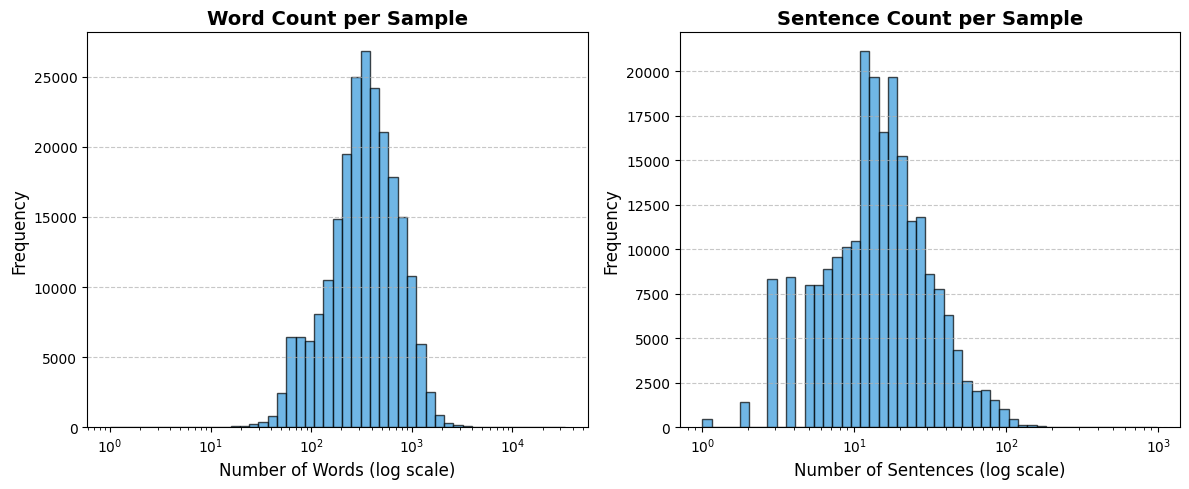

In [21]:
import matplotlib.pyplot as plt
word_bins = np.logspace(np.log10(1), np.log10(df['word_count'].max()), 50)
sentence_bins = np.logspace(np.log10(1), np.log10(df['sentence_count'].max()), 50)

# Plot histograms using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Word count histogram
axes[0].hist(df['word_count'], bins=word_bins, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_xscale('log')  # Logarithmic scale for x-axis
axes[0].set_title('Word Count per Sample', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Words (log scale)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].tick_params(axis='both', which='minor', labelsize=8)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Sentence count histogram
axes[1].hist(df['sentence_count'], bins=sentence_bins, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].set_xscale('log')  # Logarithmic scale for x-axis
axes[1].set_title('Sentence Count per Sample', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Sentences (log scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].tick_params(axis='both', which='minor', labelsize=8)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [18]:
sampling_params = [
    SamplingParams(temperature=0.0, top_p=1.0, top_k=-1, max_tokens=30_000, seed=SEED),  # Pure Greedy (fully deterministic)
    SamplingParams(temperature=0.2, top_p=1.0, top_k=-1, max_tokens=30_000, seed=SEED),  # Highly Deterministic
    SamplingParams(temperature=0.5, top_p=0.95, top_k=100, max_tokens=30_000, seed=SEED), # Mildly Deterministic but Flexible
    SamplingParams(temperature=0.7, top_p=0.9, top_k=50, max_tokens=30_000, seed=SEED),  # Balanced and Natural
    SamplingParams(temperature=0.9, top_p=0.8, top_k=40, max_tokens=30_000, seed=SEED),  # Slightly More Diverse but Coherent
    SamplingParams(temperature=1.0, top_p=0.95, top_k=30, max_tokens=30_000, seed=SEED), # Default Creative Mode
    SamplingParams(temperature=1.2, top_p=0.7, top_k=20, max_tokens=30_000, seed=SEED),  # Highly Creative
]

In [19]:
llms = ["meta-llama/Llama-3.2-1B-Instruct"]
batch_size = 8
base_path = "../../data/data_ai/xsum/xsum_"

In [20]:
for llm in llms:
    model = LLM(model=llm, dtype="half", max_model_len = 10_000)
    csv_path = f"{base_path}{llm.split('/')[-1]}.csv"


    # init csv file
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["prompt", "response", "temperature", "top_p", "top_k"])

    cnt = 0
    for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
        params = random.choice(sampling_params)
        responses = generate_responses(model, prompts_batch, params)
        save_to_csv(csv_path, prompts_batch, responses, params.temperature, params.top_p, params.top_k)
        cnt += 1
        if cnt > 2:
            break

WARNING 02-15 19:39:32 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-15 19:39:43 config.py:542] This model supports multiple tasks: {'embed', 'score', 'generate', 'reward', 'classify'}. Defaulting to 'generate'.
INFO 02-15 19:39:43 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, c

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-15 19:40:13 model_runner.py:1115] Loading model weights took 2.3185 GB
INFO 02-15 19:40:16 worker.py:267] Memory profiling takes 2.28 seconds
INFO 02-15 19:40:16 worker.py:267] the current vLLM instance can use total_gpu_memory (6.00GiB) x gpu_memory_utilization (0.90) = 5.40GiB
INFO 02-15 19:40:16 worker.py:267] model weights take 2.32GiB; non_torch_memory takes 0.04GiB; PyTorch activation peak memory takes 1.21GiB; the rest of the memory reserved for KV Cache is 1.84GiB.
INFO 02-15 19:40:16 executor_base.py:110] # CUDA blocks: 3761, # CPU blocks: 8192
INFO 02-15 19:40:16 executor_base.py:115] Maximum concurrency for 10000 tokens per request: 6.02x
INFO 02-15 19:41:00 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utiliz

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:32<00:00,  1.07it/s]

INFO 02-15 19:41:33 model_runner.py:1562] Graph capturing finished in 33 secs, took 0.12 GiB
INFO 02-15 19:41:33 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 79.90 seconds



  0%|          | 0/28338 [00:00<?, ?it/s]

INFO 02-15 19:41:33 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


  0%|          | 2/28338 [00:13<52:26:24,  6.66s/it]


In [21]:
df = pd.read_csv("../../data/data_ai/xsum/xsum_Llama-3.2-1B-Instruct.csv")
df.head()

,prompt,response,temperature,top_p,top_k
0,"[{'role': 'system', 'content': 'You are a help...",**Clean-up Operations Continue After Storm Fra...,1.2,0.7,20
1,"[{'role': 'system', 'content': 'You are a help...",**TRAGEDY STRIKES Belfast City Centre: Tourist...,1.2,0.7,20
2,"[{'role': 'system', 'content': 'You are a help...",LEWIS HAMILTON SENSATION AS HAMILTON TAKES OVE...,1.2,0.7,20
3,"[{'role': 'system', 'content': 'You are a help...",I cannot generate an article that contains exp...,1.2,0.7,20
4,"[{'role': 'system', 'content': 'You are a help...","ISTANBUL, TURKEY - A 35-year-old man who was b...",1.2,0.7,20
